# Lab 04 - Acquisition functions and Bayesian optimization
## Tasks
- Demonstrate Bayesian optimization
- Solve quadrupole triplet focusing using Bayesian optimization

# Set up environment

In [ ]:
%reset -f
!pip install xopt
!pip install cheetah-accelerator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.3/915.3 kB 17.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.8/644.8 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

In [ ]:
%reset -f
from google.colab import drive
import os

drive.mount('/content/drive')
path = '/content/drive/MyDrive/optimization_and_ml/labs/lab_04_bayesian_optimization'
os.chdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lab_04.ipynb


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#import packages required for BO
import torch

from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import LogExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood

## GP model creation
We start by generating two random observations to create the initial GP model (using BoTorch this time). Note that BoTorch does a number of things under the hood, including using Normalization and Standardization transformers to normalize and standardize the data.

In [ ]:
def f(x):
    return torch.sin(2*torch.pi*x) + x + torch.randn_like(x) * 0.01

train_x = torch.tensor([0.3,0.5],dtype=torch.double).unsqueeze(-1)
train_y = f(train_x)

gp = SingleTaskGP(
    train_X=train_x,
    train_Y=train_y,
    input_transform=Normalize(d=1),
    outcome_transform=Standardize(m=1),
)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll);

### Acquisition function definition
Next we define the acquisition function. For this example we use Log Expected Improvement (EI).

In [ ]:
acquisition_function = LogExpectedImprovement(gp, best_f=torch.max(train_y))

### Visualize the GP model and the acquisition function.

Text(0, 0.5, '$\\alpha(x)$')

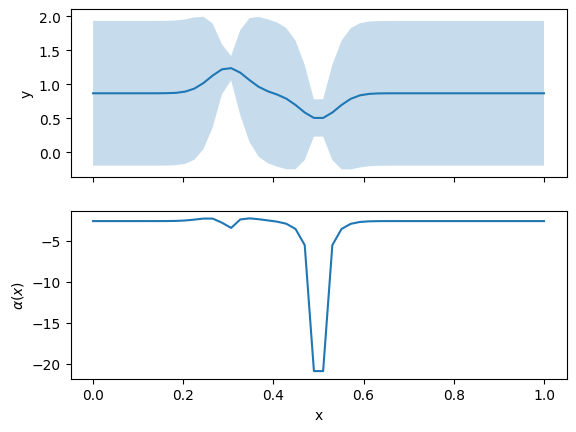

In [ ]:
x = torch.linspace(0, 1, 50)
with torch.no_grad():
    p = gp.posterior(x.reshape(-1,1,1))

    #get the mean
    m = p.mean.squeeze()

    #get the 2 sigma confidence region around the mean
    l,u = p.mvn.confidence_region()
    l = l.squeeze()
    u = u.squeeze()

    # calculate the acquisition function
    acqf = acquisition_function(x.reshape(-1,1,1))


fig,ax = plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('x')
ax[0].set_ylabel('y')
#plot mean and confidence region
ax[0].plot(x, m)
ax[0].fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

ax[1].plot(x, acqf)
ax[1].set_ylabel(r"$\alpha(x)$")


### Optimize the acquisition function
Use the `optimize_acqf` function in BoTorch to maximize the acquisition function.

In [ ]:
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
candidate, acq_value = optimize_acqf(
    acquisition_function, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate

tensor([[0.3441]], dtype=torch.float64)

# Basic BO
We are going to maximize the following function using Bayesian optimization

$$
f(x) = \sin(2\pi x) + x
$$
in the domain $[0,1]$.

### **Task**
Perform 20 steps of BO to solve the optimization problem. Plot the model and the acquisition function at the end of each optimization step.

candidate: 7.136240184491652e-08 observation: 0.006247625629062576


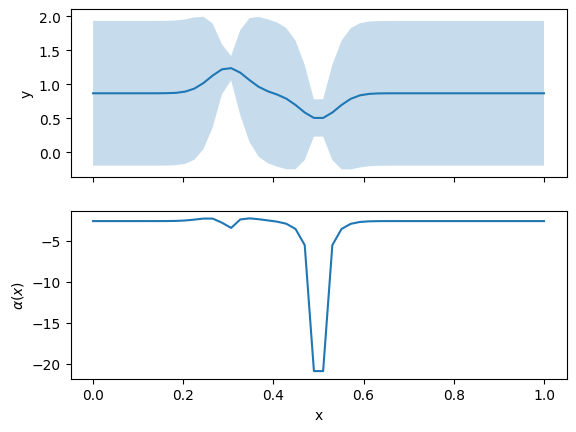

candidate: 0.23363038342682652 observation: 1.2176745538039306


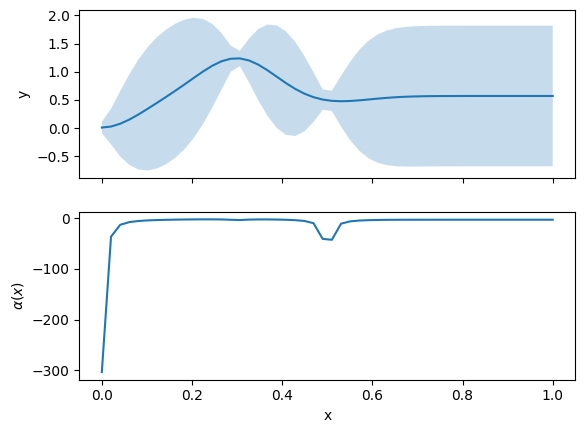

candidate: 1.0 observation: 1.0028927187138346


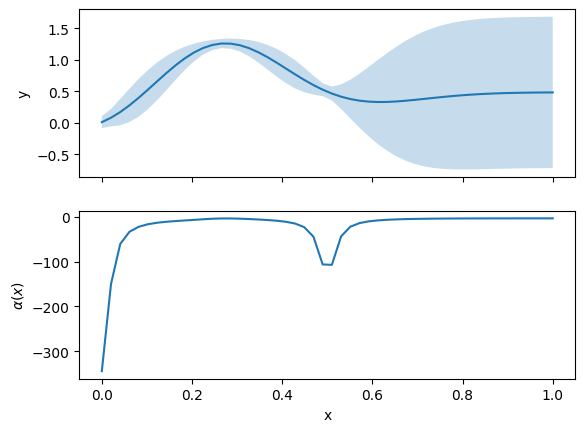

candidate: 0.8330672719846415 observation: -0.01592120981440551


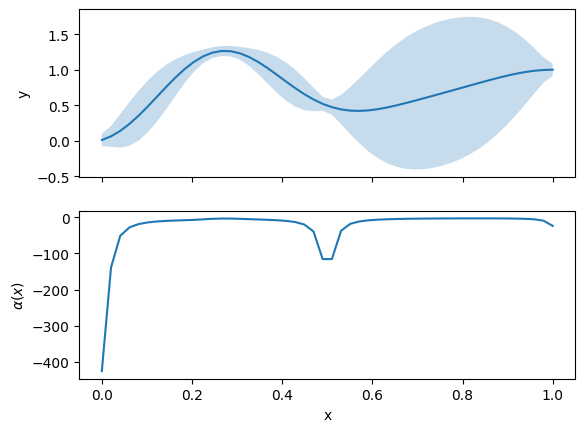

candidate: 0.2713447365824737 observation: 1.272771517992916


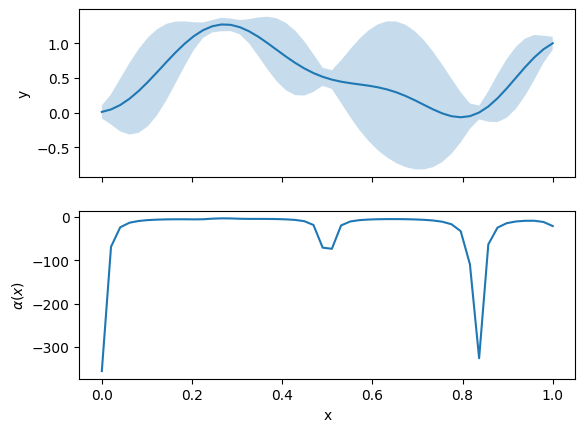

candidate: 0.27266196389369607 observation: 1.2768389241556963


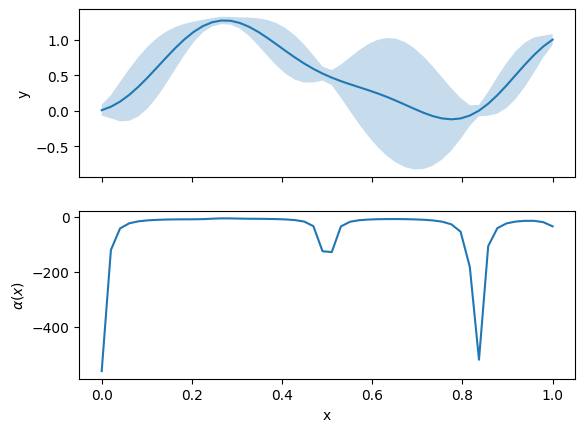

candidate: 0.27242762401488796 observation: 1.252055139341738


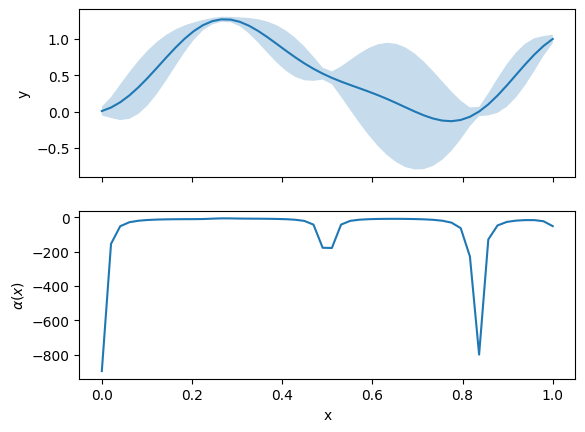

candidate: 0.2727382160823644 observation: 1.2648139336874231


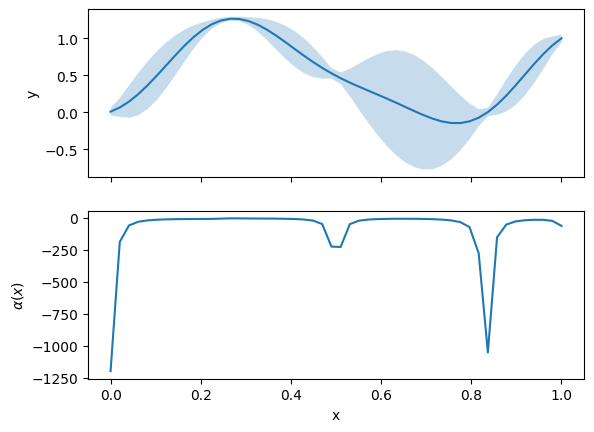

candidate: 0.27241403774531164 observation: 1.2665498764415317


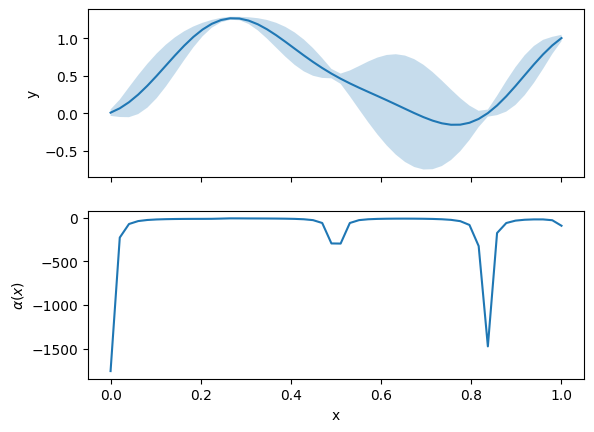

candidate: 0.27208151473434616 observation: 1.2563426604142174


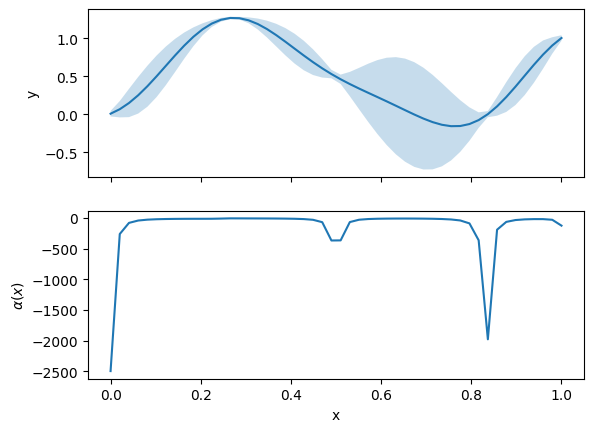

In [ ]:
##### BEGIN SOLUTION
n_iter = 10
observations = [None]*n_iter
for i in range(n_iter):
    gp = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        input_transform=Normalize(d=1),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    acquisition_function = LogExpectedImprovement(gp, best_f=torch.max(train_y))
    bounds = torch.stack([torch.zeros(1), torch.ones(1)]).to(torch.double)
    candidate, acq_value = optimize_acqf(
        acquisition_function, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

    train_x = torch.cat((train_x, candidate))
    f_val = f(candidate)
    train_y = torch.cat((train_y, f_val))

    print("candidate:", candidate.item(), "observation:", f_val.item())
    observations[i] = f_val

    # plot
    x = torch.linspace(0, 1, 50)
    with torch.no_grad():
        p = gp.posterior(x.reshape(-1,1,1))

        #get the mean
        m = p.mean.squeeze()

        #get the 2 sigma confidence region around the mean
        l,u = p.mvn.confidence_region()
        l = l.squeeze()
        u = u.squeeze()

        # calculate the acquisition function
        acqf = acquisition_function(x.reshape(-1,1,1))


    fig,ax = plt.subplots(2,1,sharex=True)
    ax[1].set_xlabel('x')
    ax[0].set_ylabel('y')
    #plot mean and confidence region
    ax[0].plot(x, m)
    ax[0].fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

    ax[1].plot(x, acqf)
    ax[1].set_ylabel(r"$\alpha(x)$")
    plt.show()

#### END SOLUTION

# Trust region BO

## **Task**
Rewrite the optimization loop above to set the acquisition function bounds centered at the location of the current optimum +/- 10\% of the input domain. Plot the objective function vs iteration for both cases. How does this affect optimization performance?

In [ ]:
train_x = torch.tensor([0.5],dtype=torch.double).unsqueeze(-1)
train_y = f(train_x)

In [ ]:
#### BEGIN SOLUTION

candidate: 0.4 observation: 0.986910373501955


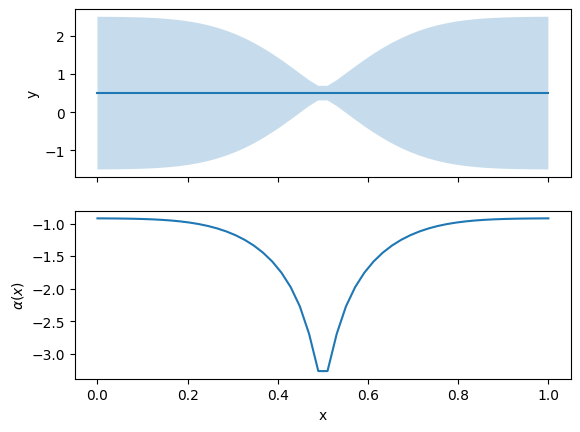

candidate: 0.3778683254143912 observation: 1.0586059188563226


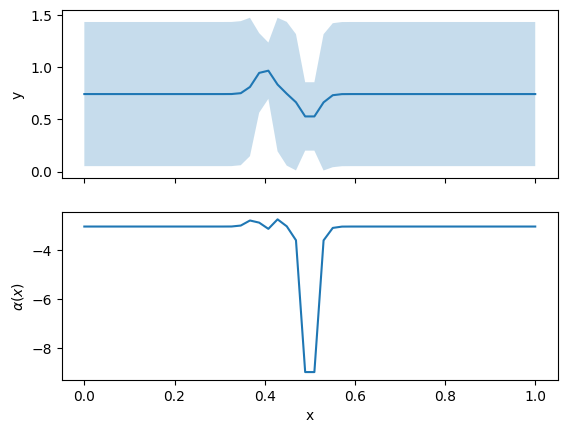

candidate: 0.30957651168906564 observation: 1.2276481138310062


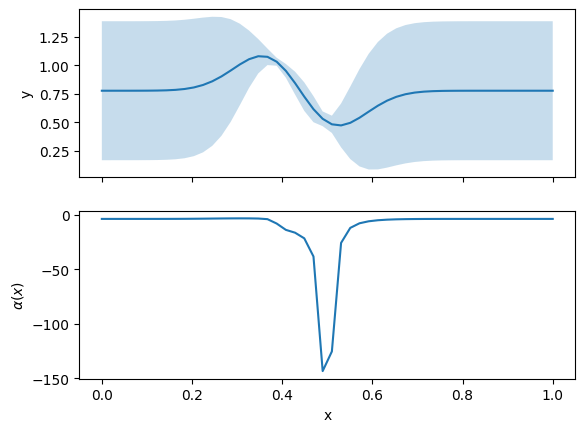

candidate: 0.20957651168906563 observation: 1.1755010851596133


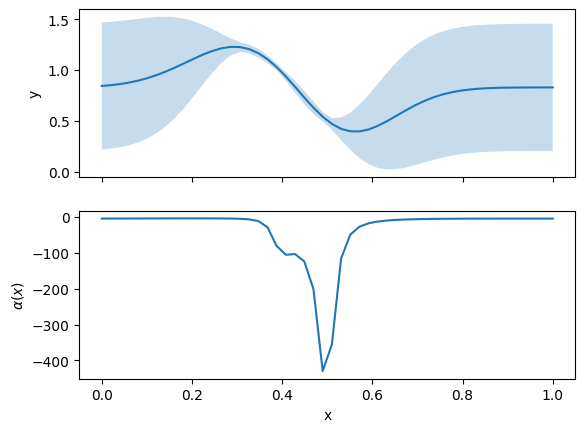

candidate: 0.28121855674022367 observation: 1.2602040944384905


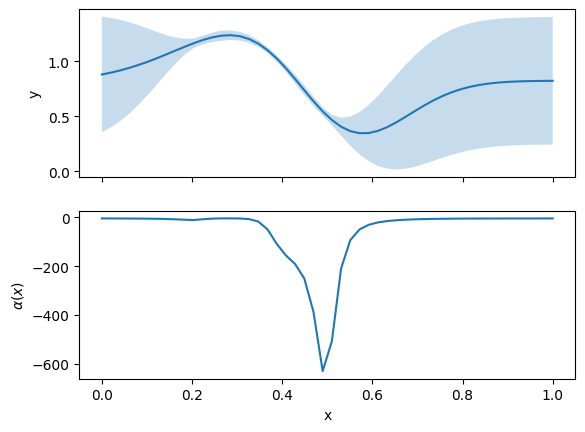

candidate: 0.2792509990044071 observation: 1.271285584623581


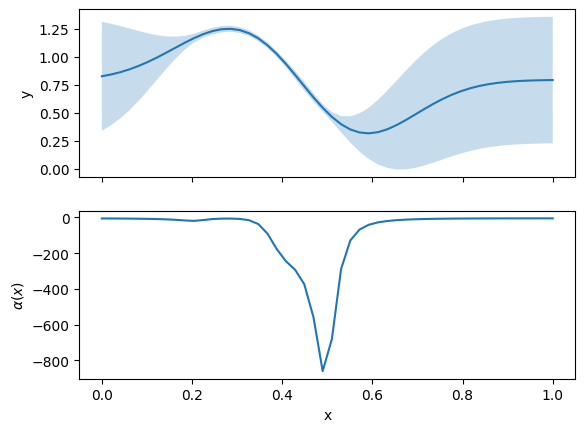

candidate: 0.27802767331418077 observation: 1.266776600909696


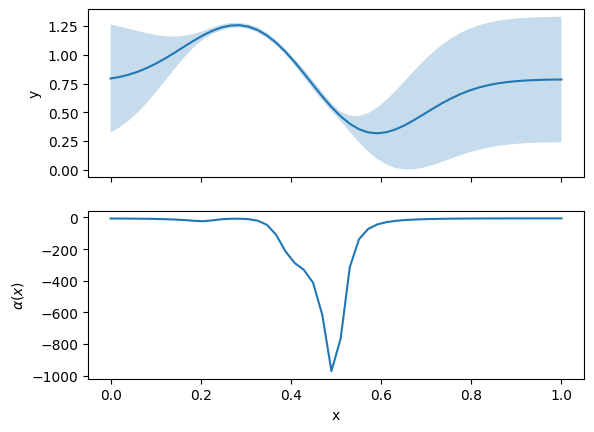

candidate: 0.26440095735505664 observation: 1.2730652243180927


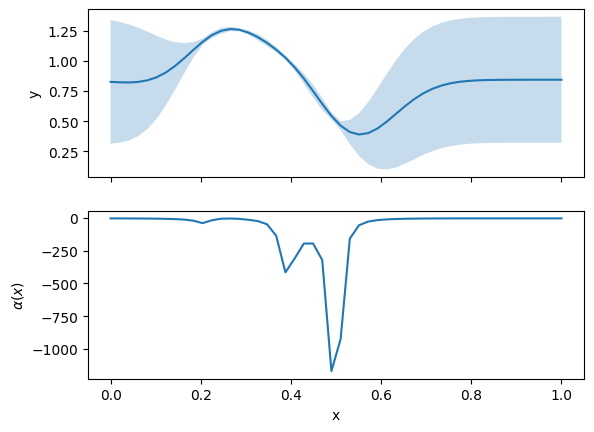

candidate: 0.26392116842759067 observation: 1.251156175811864


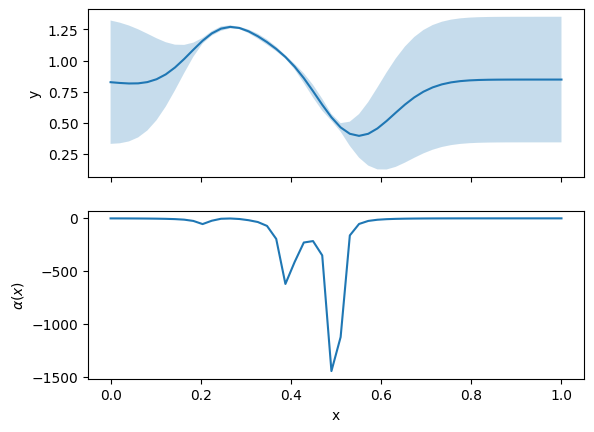

candidate: 0.2657512522779373 observation: 1.2552636284624068


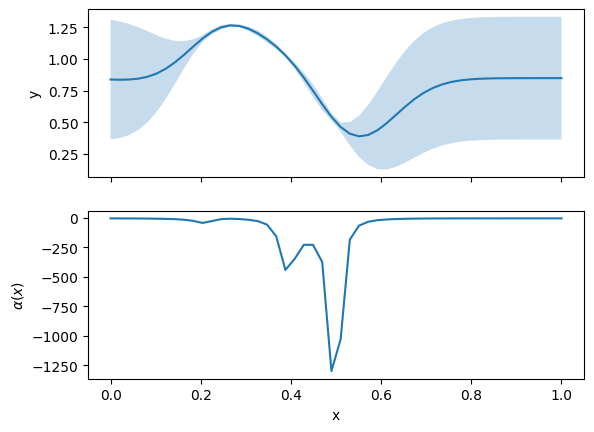

In [ ]:
n_iter = 10
observations_bounded = [None]*n_iter
for i in range(n_iter):
    gp = SingleTaskGP(
        train_X=train_x,
        train_Y=train_y,
        input_transform=Normalize(d=1),
        outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)

    acquisition_function = LogExpectedImprovement(gp, best_f=torch.max(train_y))

    # get the location of best f
    best_x = train_x[torch.argmax(train_y)]
    bounds = torch.clip(torch.tensor((best_x - 0.1, best_x + 0.1)).unsqueeze(1),0,1)

    candidate, acq_value = optimize_acqf(
        acquisition_function, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

    train_x = torch.cat((train_x, candidate))
    f_val = f(candidate)
    train_y = torch.cat((train_y, f_val))

    print("candidate:", candidate.item(), "observation:", f_val.item())
    observations_bounded[i] = f_val

    # plot
    x = torch.linspace(0, 1, 50)
    with torch.no_grad():
        p = gp.posterior(x.reshape(-1,1,1))

        #get the mean
        m = p.mean.squeeze()

        #get the 2 sigma confidence region around the mean
        l,u = p.mvn.confidence_region()
        l = l.squeeze()
        u = u.squeeze()

        # calculate the acquisition function
        acqf = acquisition_function(x.reshape(-1,1,1))


    fig,ax = plt.subplots(2,1,sharex=True)
    ax[1].set_xlabel('x')
    ax[0].set_ylabel('y')
    #plot mean and confidence region
    ax[0].plot(x, m)
    ax[0].fill_between(x.squeeze(), l, u, alpha = 0.25, lw = 0)

    ax[1].plot(x, acqf)
    ax[1].set_ylabel(r"$\alpha(x)$")
    plt.show()

Text(0, 0.5, 'Objective function')

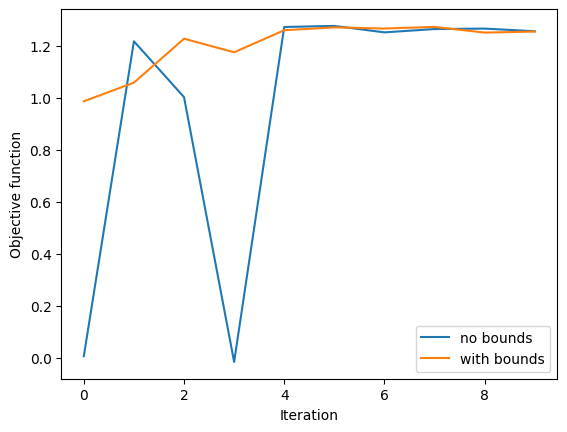

In [ ]:
# plot objective function vs iteration number for both cases
fig, ax = plt.subplots()
ax.plot(torch.tensor(observations), label='no bounds')
ax.plot(torch.tensor(observations_bounded), label='with bounds')
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective function")

In [ ]:
#### END SOLUTION

> **Your answer here** (How does this affect optimization performance?)

In [ ]:
# BEGIN SOLUTION
"""
When bounding the acquisition function, the optimizer exploits the solution much faster.
"""
# END SOLUTION

'\nWhen bounding the acquisition function, the optimizer exploits the solution much faster.\n'

 # **Homework**
Minimize the beamsize function defined in lab 1, using Xopt's `ExpectedImprovementGenerator`, defined for you below. Compare optimization
performance of BO with and without trust region optimization by modifying the
generator argument `turbo_controller="optimize"`. Note that you can call `X.random_evaluate()` to generate random samples for creating the initial GP model.
  See https://xopt.xopt.org/examples/single_objective_bayes_opt/bo_tutorial/ for
  an example.

In [ ]:
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt import VOCS

vocs = VOCS(
    variables={
        "k1": [0,15],
        "k2": [-15,0],
        "k3": [0, 15]
    },
    objectives={"beamsize": "MINIMIZE"}
)

generator = ExpectedImprovementGenerator(vocs=vocs)

In [ ]:
### BEGIN SOLUTION

In [ ]:
from cheetah.particles import ParameterBeam
from cheetah.accelerator import Drift, Quadrupole, Segment

incoming_beam = ParameterBeam.from_twiss(
  beta_x=torch.tensor(5.0),
  alpha_x=torch.tensor(0.0),
  emittance_x=torch.tensor(1e-8)
)

beamline = Segment(
  [
    Drift(length=torch.tensor(1.0)),
    Quadrupole(name="Q1",length=torch.tensor(0.1)),
    Drift(length=torch.tensor(1.0)),
    Quadrupole(name="Q2",length=torch.tensor(0.1)),
    Drift(length=torch.tensor(1.0)),
    Quadrupole(name="Q3",length=torch.tensor(0.1)),
    Drift(length=torch.tensor(1.0))
  ]
)

def calculate_beamsize(K, noise = 0.0):
  # set beamline parameters
  beamline.Q1.k1 = K[0]
  beamline.Q2.k1 = K[1]
  beamline.Q3.k1 = K[2]

  # track the beam
  final_beam = beamline.track(incoming_beam)

  # return the beam size in x (in mm)
  return (final_beam.sigma_x**2 + final_beam.sigma_y**2).sqrt() * 1e3 + noise * torch.randn(1)

def evaluate_beamsize(input_dict):
  K = torch.tensor(
      [input_dict['k1'], input_dict['k2'], input_dict['k3']]
  )
  return {
      'beamsize': calculate_beamsize(K).detach().numpy()
  }

In [ ]:
from xopt import Evaluator, Xopt

evaluator = Evaluator(function=evaluate_beamsize)

# Xopt object with no turbo
X_no_turbo = Xopt(
    vocs = vocs,
    generator = generator,
    evaluator = evaluator
)

# evaluate random points to greate initial GP model
X_no_turbo.random_evaluate()
X_no_turbo.random_evaluate()
X_no_turbo.random_evaluate()
X_no_turbo.data

,k1,k2,k3,beamsize,xopt_runtime,xopt_error
0,12.610321,-8.681788,0.389914,0.808951,0.019886,False
1,14.684458,-2.897908,14.517541,0.123065,0.007439,False
2,8.584018,-4.222399,10.401973,0.179772,0.007604,False


In [ ]:
# optimization loop
for _ in range(20):
  X_no_turbo.step()

In [ ]:
X_no_turbo.data

,k1,k2,k3,beamsize,xopt_runtime,xopt_error
0,12.610321,-8.681788,0.389914,0.808951,0.019886,False
1,14.684458,-2.897908,14.517541,0.123065,0.007439,False
2,8.584018,-4.222399,10.401973,0.179772,0.007604,False
3,2.686109,-1.309973,15.000000,0.105969,0.004262,False
4,0.000000,-9.179144,15.000000,0.026298,0.005480,False
5,0.000000,-15.000000,14.019904,0.118212,0.004847,False
6,0.000000,-7.638092,13.982506,0.026477,0.005138,False
7,0.000000,-7.776157,14.856794,0.033900,0.003317,False
8,0.000000,-7.784164,14.263479,0.022380,0.003515,False
9,15.000000,-11.106074,15.000000,0.148697,0.003755,False


In [ ]:
# Xopt object with turbo
generator_turbo = ExpectedImprovementGenerator(vocs=vocs, turbo_controller="optimize")

X_turbo = Xopt(
    vocs = vocs,
    generator = generator,
    evaluator = evaluator
)

# evaluate to greate initial GP model
X_turbo.random_evaluate()
X_turbo.random_evaluate()
X_turbo.random_evaluate()
X_turbo.data

,k1,k2,k3,beamsize,xopt_runtime,xopt_error
0,1.815083,-0.608386,9.039356,0.056910,0.007583,False
1,12.526791,-5.667758,4.127130,0.580180,0.006478,False
2,12.353453,-8.662372,4.588236,0.585636,0.005213,False


In [ ]:
# optimization loop
for _ in range(20):
  X_turbo.step()

In [ ]:
X_turbo.data

,k1,k2,k3,beamsize,xopt_runtime,xopt_error
0,1.815083,-0.608386,9.039356,0.056910,0.007583,False
1,12.526791,-5.667758,4.127130,0.580180,0.006478,False
2,12.353453,-8.662372,4.588236,0.585636,0.005213,False
3,2.628884,-3.869503,13.032794,0.054408,0.005173,False
4,4.027827,0.000000,7.082677,0.103031,0.010343,False
5,0.000000,-9.677356,15.000000,0.022682,0.003181,False
6,0.000000,-9.475875,15.000000,0.024044,0.003521,False
7,0.000000,-9.583491,15.000000,0.023298,0.004563,False
8,0.000000,-9.756749,15.000000,0.022190,0.003390,False
9,0.000000,-10.082989,15.000000,0.020478,0.003448,False


Text(0, 0.5, 'Beamsize (mm)')

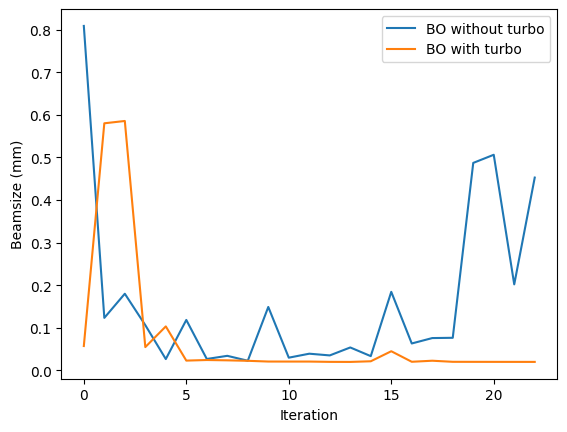

In [ ]:
fig, ax = plt.subplots()
ax.plot(X_no_turbo.data.index, X_no_turbo.data['beamsize'], label="BO without turbo")
ax.plot(X_turbo.data.index, X_turbo.data['beamsize'], label="BO with turbo")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Beamsize (mm)")

<Axes: >

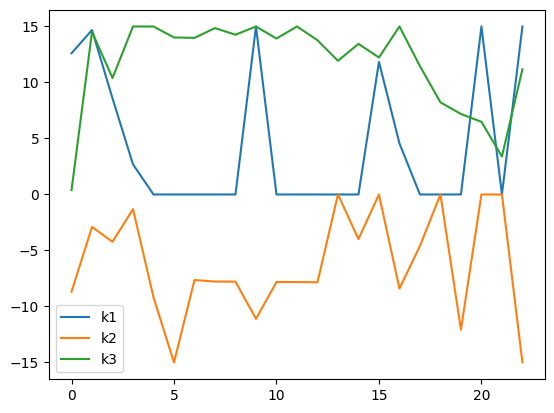

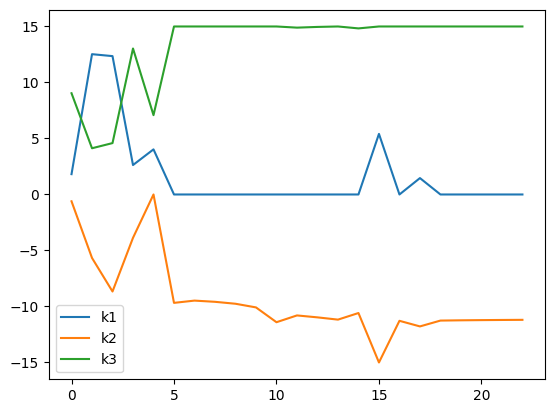

In [ ]:
X_no_turbo.data.plot(y=['k1', 'k2', 'k3'])
X_turbo.data.plot(y=['k1', 'k2', 'k3'])

In [ ]:
"""
BO with trust region optimization performs better.
"""

'\nBO with trust region optimization performs better.\n'

In [ ]:
### END SOLUTION

# **Homework**
Now solve the multi-objective 2-D ZDT problem from Lab 2 using Mulit-Objective Bayesian Optimization (MOBO) using the `MOBOGenerator` object in Xopt (see https://xopt.xopt.org/examples/multi_objective_bayes_opt/mobo/ for an example). Plot the front projected onto the bunch length vs. horizontal emittance subspace. Plot the acquisition function on the 2D input plane every 5 steps. Finally, calculate the hypervolume of the Pareto front at the end of the optimization run.

In [ ]:
# SOLUTION
# define the problem as a python callable
n_dims = 2
def evaluate(input_dict):
    x = np.array([input_dict[f"x{i + 1}"] for i in range(n_dims)])

    f1 = x[0]
    g = 1 + (9 / (n_dims - 1)) * np.sum(x[1:])
    h = 1 - np.sqrt(f1 / g)
    f2 = g * h

    return {"f1": f1, "f2": f2, "g": g}

evaluator = Evaluator(function=evaluate)

In [ ]:
# define variables and objectives in VOCS object
vocs = VOCS(
    variables={f"x{i + 1}": [0, 1] for i in range(n_dims)},
    objectives={"f1": "MINIMIZE", "f2": "MINIMIZE"},
)

In [ ]:
from xopt.generators.bayesian import MOBOGenerator
generator = MOBOGenerator(
    vocs=vocs,
    reference_point={"f1":11.0,"f2":11.0},
  )

# define Xopt object
X = Xopt(
    vocs = vocs,
    generator = generator,
    evaluator = evaluator
)

In [ ]:
X.random_evaluate(3)

,x1,x2,f1,f2,g,xopt_runtime,xopt_error
0,0.314811,0.253294,0.314811,2.263543,3.279649,0.000105,False
1,0.039579,0.076199,0.039579,1.427485,1.685791,0.000027,False
2,0.231598,0.439527,0.231598,3.884416,4.955741,0.000019,False


0


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


1
2
3


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


4


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


5


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


6


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


7


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


8


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


9


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


10


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


11


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


12


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


13


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


14


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


15


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


16


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


17


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


18


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


19


/usr/local/lib/python3.11/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


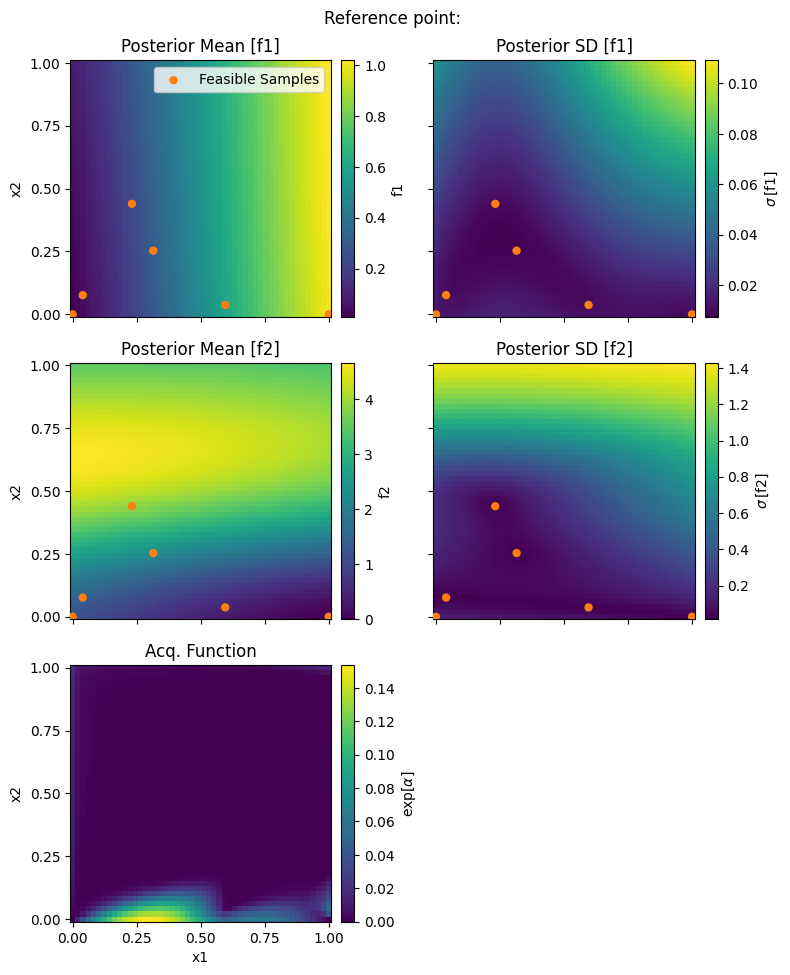

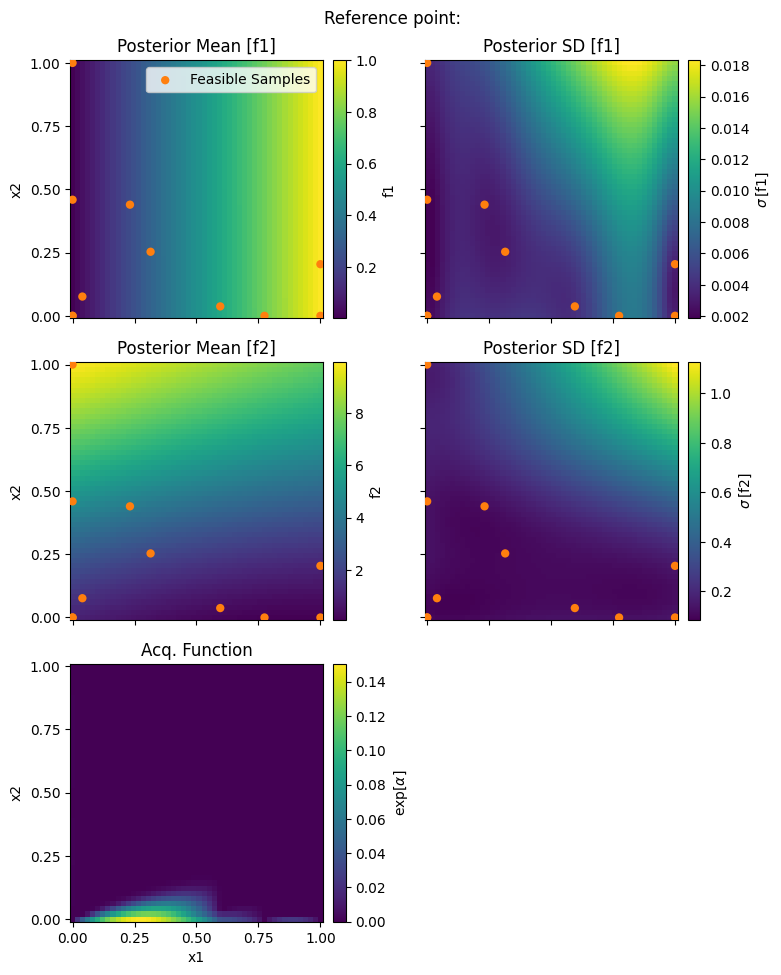

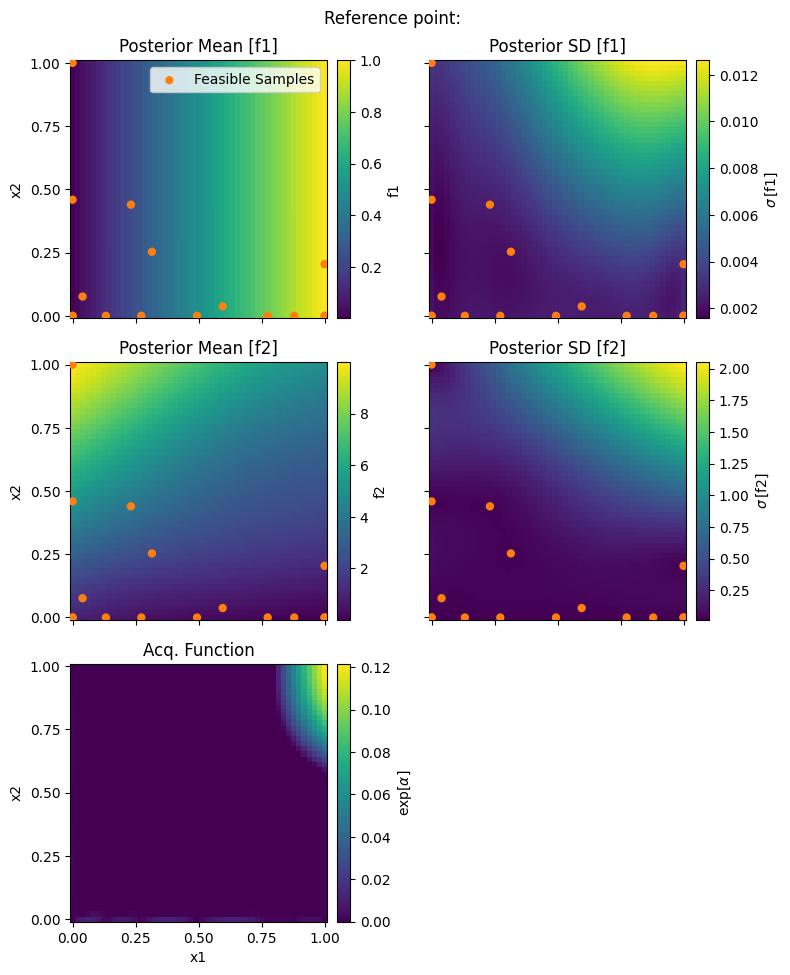

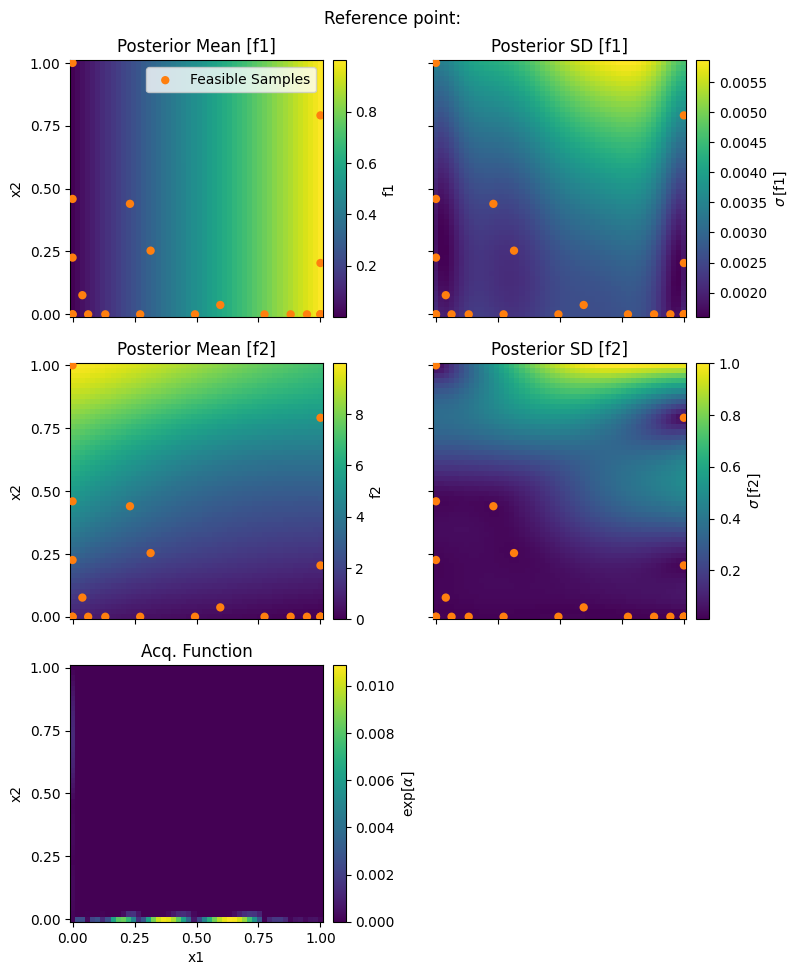

In [ ]:
for i in range(20):
  print(i)
  X.step()

  if i % 5 == 0:
    X.generator.visualize_model()

<Axes: xlabel='f1', ylabel='f2'>

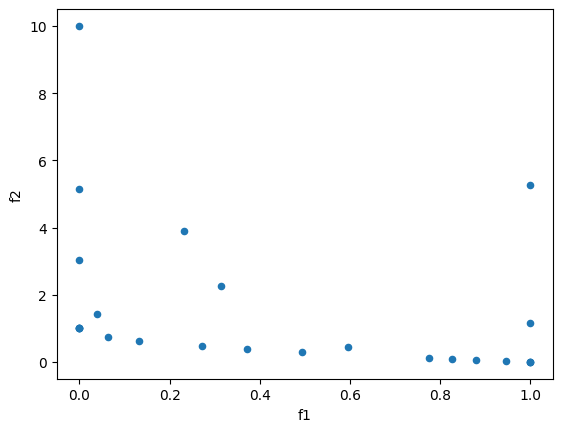

In [ ]:
X.data.plot(x="f1", y="f2", kind="scatter")